Francisco José Durá Galiana

# Procesamiento de datos

En el siguiente notebook se muestra el procesamiento y guardado de datos procesados para su uso en los modelos de predicción

In [2]:
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

import os
import keras
import h5py
import librosa
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import seaborn as sns

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Leer datos
Las siguientes funciones son utilizadas para procesar las canciones (leer, partir y convertir en espectrogramas). Éstas son modificaciones de las funciones por H. Guimares (2017).

**`splitsongs(X, y, window, overlap)`**
 - `X`: Audio completo
 - `y`: Etiqueta del audio
 - `window`: tamaño de los audios de salida
 - `overlap`: ratio de solape entre audios

Esta funcion divide un audio en varios audios de mismo tamaño (`window`) y los devuelve con sus etiquetas correspondientes.

In [82]:
def splitsongs(X, y1, y2=None, window = 0.1, overlap = 0.5):
    # inicializar salidas
    temp_X = []
    temp_y1 = []
    if y2 is not None:
        temp_y2 = []

    xshape = X.shape[0] # tamaño del audio
    chunk = int(xshape*window) # tamaño de los audios de salida
    offset = int(chunk*(1.-overlap)) # offset donde cortar siguiente audio
    
    # Cortar cancion en trozos teniendo en cuenta los tamaños original y de salida y el offset
    spsong = [X[i:i+chunk] for i in range(0, xshape - chunk + offset, offset)]
    
    # Crear lista de salida con cortes de la cancion y target correspondiente
    for s in spsong:
        temp_X.append(s)
        temp_y1.append(y1)     
        if y2 is not None:
            temp_y2.append(y2)

    if y2 is not None:
        return np.array(temp_X), np.array(temp_y1), np.array(temp_y2)
    else:
        return np.array(temp_X), np.array(temp_y1)

**`to_melspectrogram(songs, n_fft = 1024, hop_length = 512)`**
 - `songs`: lista de audios a convertir
 - `n_fft`: Tamaño de la ventana para la transformación de Fourier
 - `hop_length`: Samples dentro de la ventana de transformación

Esta funcion convierte una lista de audios en una lista de espectrogramas de escala logarítmica utilizando transformaciones de Fourier. Los espectrogramas son las imágenes utilizadas por la red como se verá más adelante.

In [83]:
def to_melspectrogram(songs, n_fft = 1024, hop_length = 512, db_conversion=False):
    # función de transformación
    if db_conversion == True:
        melspec = lambda x: librosa.power_to_db(librosa.feature.melspectrogram(x, n_fft = n_fft, 
                                                                               hop_length = hop_length))[:,:,np.newaxis]
    else:   
         melspec = lambda x: librosa.feature.melspectrogram(x, n_fft = n_fft, hop_length = hop_length)[:,:,np.newaxis]

    # aplicar transformación a todas las canciones de entrada
    tsongs = map(melspec, songs)
    return np.array(list(tsongs))

**`read_data(src_dir, genres, song_samples, spec_format, debug = True)`**
 - `src_dir`: Directorio 
 - `genres`: Diccionario de géneros-indicador categórico
 - `song_samples`: Número de canciónes a extraer
 - `spec_format`: Función de transformación de las señales
 - `debug`: Indicador de estado debug

Esta función importa las canciones que se van a utilizar en el entrenamiento y validación del modelo y aplica las transformaciones indicadas. Devuelve un array con los espectrogramas y otro con el target.

In [84]:
def read_data(metadata, genres, tempos, song_samples, spec_format, debug = True, db_conversion=False):    
    # Inicializar listas de salida
    arr_specs = []
    arr_genres = []
    arr_tempos = []

    # Filtrar datos a procesar
    df = metadata[metadata.genre.isin(list(genres.keys()))]
    
    cuts = list(range(df.tempo.astype(int).min(),df.tempo.astype(int).max()+1,10))

    df["tempo_bin"] = pd.cut(df.tempo.astype(int), cuts, labels=list(tempos.keys()), include_lowest=True).astype(str)
    
    # Leer todos los ficheros en el directorio (cada género en una carpeta)
    for i,row in df.iterrows():
        
        file_name = row.fullpath      
        signal, sr = librosa.load(file_name)
        signal = signal[:song_samples]
 
        # Indicador cuando debug está activo
        if debug:
            print("Reading file: {}".format(file_name))
            print(tempos[row.tempo_bin])
        
        # Partir canciones en audios mas pequeños
        signals, y1, y2 = splitsongs(signal, genres[row.genre], tempos[row.tempo_bin])    

        # Convertir audio con la función definida (se utilizará la función de espectrograma)
        specs = spec_format(signals,db_conversion=db_conversion)

        # Almacenar espectrogramas y etiquetas
        arr_genres.extend(y1)
        arr_tempos.extend(y2)
        arr_specs.extend(specs)
                        
    return np.array(arr_specs), np.array(arr_genres), np.array(arr_tempos)

En el siguiente trozo de código se definen el directorio, número de ejemplos y el diccionario de géneros y se procede a la extracción de las canciones.

In [85]:
# Parámetros de extracción de canciones
gtzan_dir = r"D:\Users\franc\Documents\IMF - Deep Learning\Trabajo Master\Datasets\GTZAN\genres"
data_df = pd.read_csv(r"D:\Users\franc\Documents\IMF - Deep Learning\Trabajo Master\Scripts\gtzan_clean.csv")
song_samples = 660000
genres = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4, 
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}
tempos = {'('+str(t)+', '+str(t+10)+']':i 
          for i,t in enumerate(range(data_df.tempo.astype(int).min(),data_df.tempo.astype(int).max(),10))}

In [86]:
# Leeer datos
db_conversion = True
X, y1, y2 = read_data(data_df, genres, tempos, song_samples, to_melspectrogram, debug=False, db_conversion=db_conversion)

Podemos guardar los arrays generados para su utilización en el futuro sin tener que procesar todos los audios de nuevo utilizando `numpy.save()`:

In [88]:
if db_conversion = True:
    x_name = 'x_db_scaled.npy'
else:
    x_name = 'x_gtzan_npy.npy'
np.save(x_name, X)
np.save('y1_gtzan_npy.npy', y1)
np.save('y2_binned.npy', y2)

Finalmente convertimos la variable de target a una variable one-hot para poder utilizar en la capa de salida de la red como clasificación categórica:

In [89]:
y1 = to_categorical(y1)

In [90]:
y2 = to_categorical(y2)

## Visualización de los datos

La creación de los espectrogramas es uno de los temas principales a tener en cuenta para el entrenamiento de un modelo propio en el futuro. Éste es el único pre-procesamiento que se está haciendo a los datos antes de meterlos en la red y es importante que tengan sentido para que la red pueda extraer la información. Por este motivo he añadido una sección donde inspecciono brevemente los espectrogramas generados.

In [91]:
# Esta es una inversión del diccionario de géneros para extraer el género de los ejemplos visualizados
inv_genres = {v: k for k, v in genres.items()}
inv_tempos = {v: k for k, v in tempos.items()}

Inicialmente pinté los espectrogramas de múchas canciones para comprobar que las diferencias visuales entre géneros eran notables. A continuación se muestra una selección de 6 géneros:

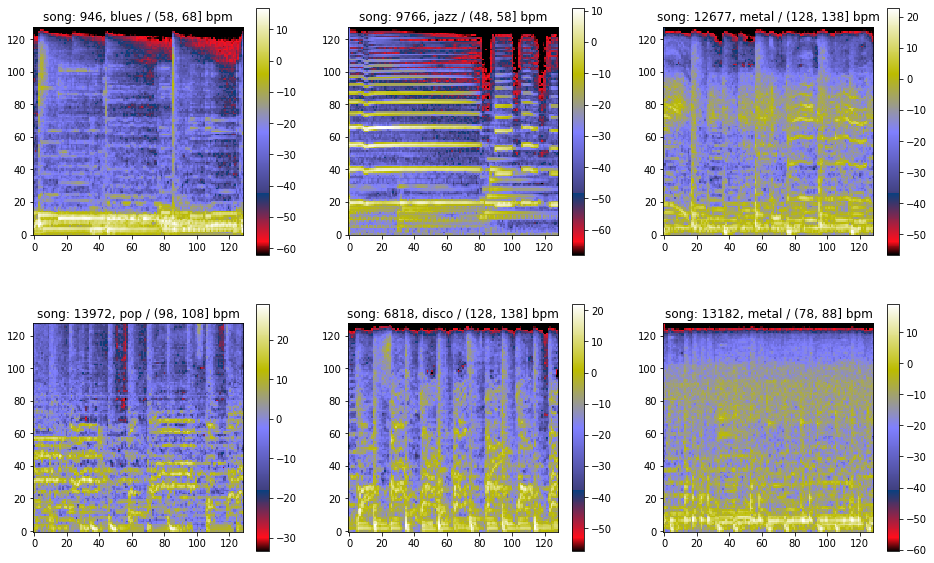

In [92]:
fig = plt.figure(figsize=(16,10))
# enumerate([17787,890,10924,6175,14749,16068])
for i,cancion in enumerate(list(np.random.randint(0, len(y1), size=6))):
    estilo = inv_genres[list(y1[cancion]).index(1.0)] # género de la canción
    tempo = inv_tempos[list(y2[cancion]).index(1.0)] # tempo de la canción
    sample1 = X[cancion,:,:].reshape(128,129) # Canción extraida

    vmax = np.int(sample1.max()) # Capar valor máximo para mejor visualización  
        
    a = fig.add_subplot(2,3,i+1) # Crear gráfico
    f = plt.imshow(sample1, cmap=plt.get_cmap('gist_stern'),vmax=vmax) # pintar
    a.invert_yaxis() # Invertir eje para que la frecuencia vaya de menor a mayor
    a.set_title("song: {}, {} / {} bpm".format(cancion, estilo, tempo))
    plt.colorbar()

plt.show()

## Partición de los datos
A continuación se procede a la partición de los datos en sets de entrenamiento y validación. Vamos a utilizar un split de entrenamiento/test de 80/20 y utilizaremos un 25% del entrenamiento para validación; resultando en un corte 60/20/20.

In [94]:
y = np.concatenate((y1,y2),axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [99]:
y1_train = y_train[:,:10]
y1_test = y_test[:,:10]
y2_train = y_train[:,10:]
y2_test = y_test[:,10:]

In [100]:
print(X_train.shape, X_test.shape)
print(y1_train.shape, y1_test.shape)
print(y2_train.shape, y2_test.shape)

(15200, 128, 129, 1) (3800, 128, 129, 1)
(15200, 10) (3800, 10)
(15200, 13) (3800, 13)


Para comprobar que la distribución de las categorías es equitativa entre los sets pintamos el siguiente gráfico de barras:

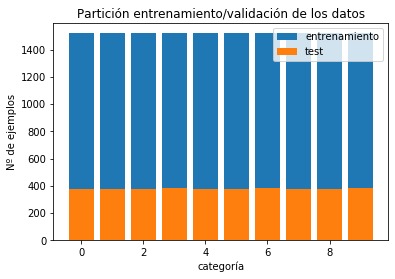

In [101]:
# Histogram for train and test 
values, count = np.unique(np.argmax(y1_train, axis=1), return_counts=True)
plt.bar(values, count, label='entrenamiento')

values, count = np.unique(np.argmax(y1_test, axis=1), return_counts=True)
plt.bar(values, count, label='test')
plt.title('Partición entrenamiento/validación de los datos')
plt.xlabel('categoría')
plt.ylabel('Nº de ejemplos')
plt.legend()
plt.show()

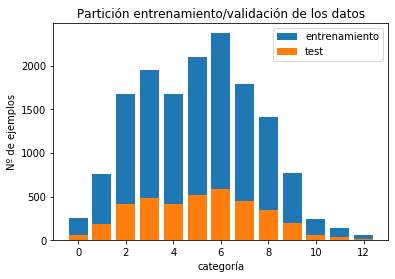

In [103]:
# Histogram for train and test 
values, count = np.unique(np.argmax(y2_train, axis=1), return_counts=True)
plt.bar(values, count, label='entrenamiento')

values, count = np.unique(np.argmax(y2_test, axis=1), return_counts=True)
plt.bar(values, count, label='test')
plt.title('Partición entrenamiento/validación de los datos')
plt.xlabel('categoría')
plt.ylabel('Nº de ejemplos')
plt.legend()
plt.show()

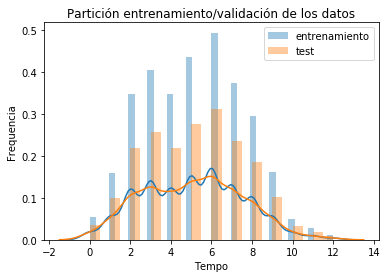

In [104]:
# Histogram for train and test 
sns.distplot(np.argmax(y2_train, axis=1), label='entrenamiento')
sns.distplot(np.argmax(y2_test, axis=1), label='test')
plt.title('Partición entrenamiento/validación de los datos')
plt.xlabel('Tempo')
plt.ylabel('Frequencia')
plt.legend()
plt.show()

Como se puede ver en el gráfico los sets parecen estar divididos equitativamente para todas las categorías así que procedemos a la construcción y entrenamiento del modelo.